Turns out the analytic error convolution isn't very good, which I demonstrate here. Instead, we should just approximate the estimation value.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pzflow import Flow
from utils import LSSTErrorModel

In [2]:
#flow = Flow(file="saved-flows/desc-dc2-dr6-redshift-flow.pkl")
flow = Flow(file="saved-flows/desc-dc2-redshift-flow.pkl")

draw samples from the flow

In [13]:
samples = flow.sample(10000, seed=0)

add LSST errors

In [14]:
s = LSSTErrorModel()(samples)

Let's look at low-redshift galaxies without any missing bands

In [15]:
s = s.query("u < 90 & g < 90 & r < 90 & i < 90 & z < 90 & y < 90 & redshift < 1.7")

First let's calculate posteriors for the true magnitudes, the noisy magnitudes without error convolution, and the noisy magnitudes with error convolution

In [22]:
N = 50
grid = np.arange(0, 2, 0.01)
pdfs0 = flow.posterior(samples.iloc[s.index[:N]], column="redshift", grid=grid, convolve_err=False)
pdfs1 = flow.posterior(s[:N], column="redshift", grid=grid, convolve_err=False)
pdfs2 = flow.posterior(s[:N], column="redshift", grid=grid, convolve_err=True)

Now let's convolve the errors by sampling

In [101]:
Gsamples = []
np.random.seed(0)
J = 10000
for gal in s.values[:N]:
    for i in range(J):
        Gsamples.append( list(gal[:1]) + list(np.random.normal(gal[1:7], gal[7:])) )
Gsamples = pd.DataFrame(Gsamples, columns=samples.columns)

In [104]:
%%time
pdfs3 = flow.posterior(Gsamples, column="redshift", grid=grid, convolve_err=False, normalize=False)
pdfs3 = pdfs3.reshape(N, J, -1).sum(axis=1)
pdfs3 /= (pdfs3.sum(axis=-1) * (grid[1] - grid[0])).reshape(-1,1)

CPU times: user 48min 11s, sys: 2h 56min 31s, total: 3h 44min 43s
Wall time: 19min 51s


If we plot the results, we see that the sampling convolution is a lot better

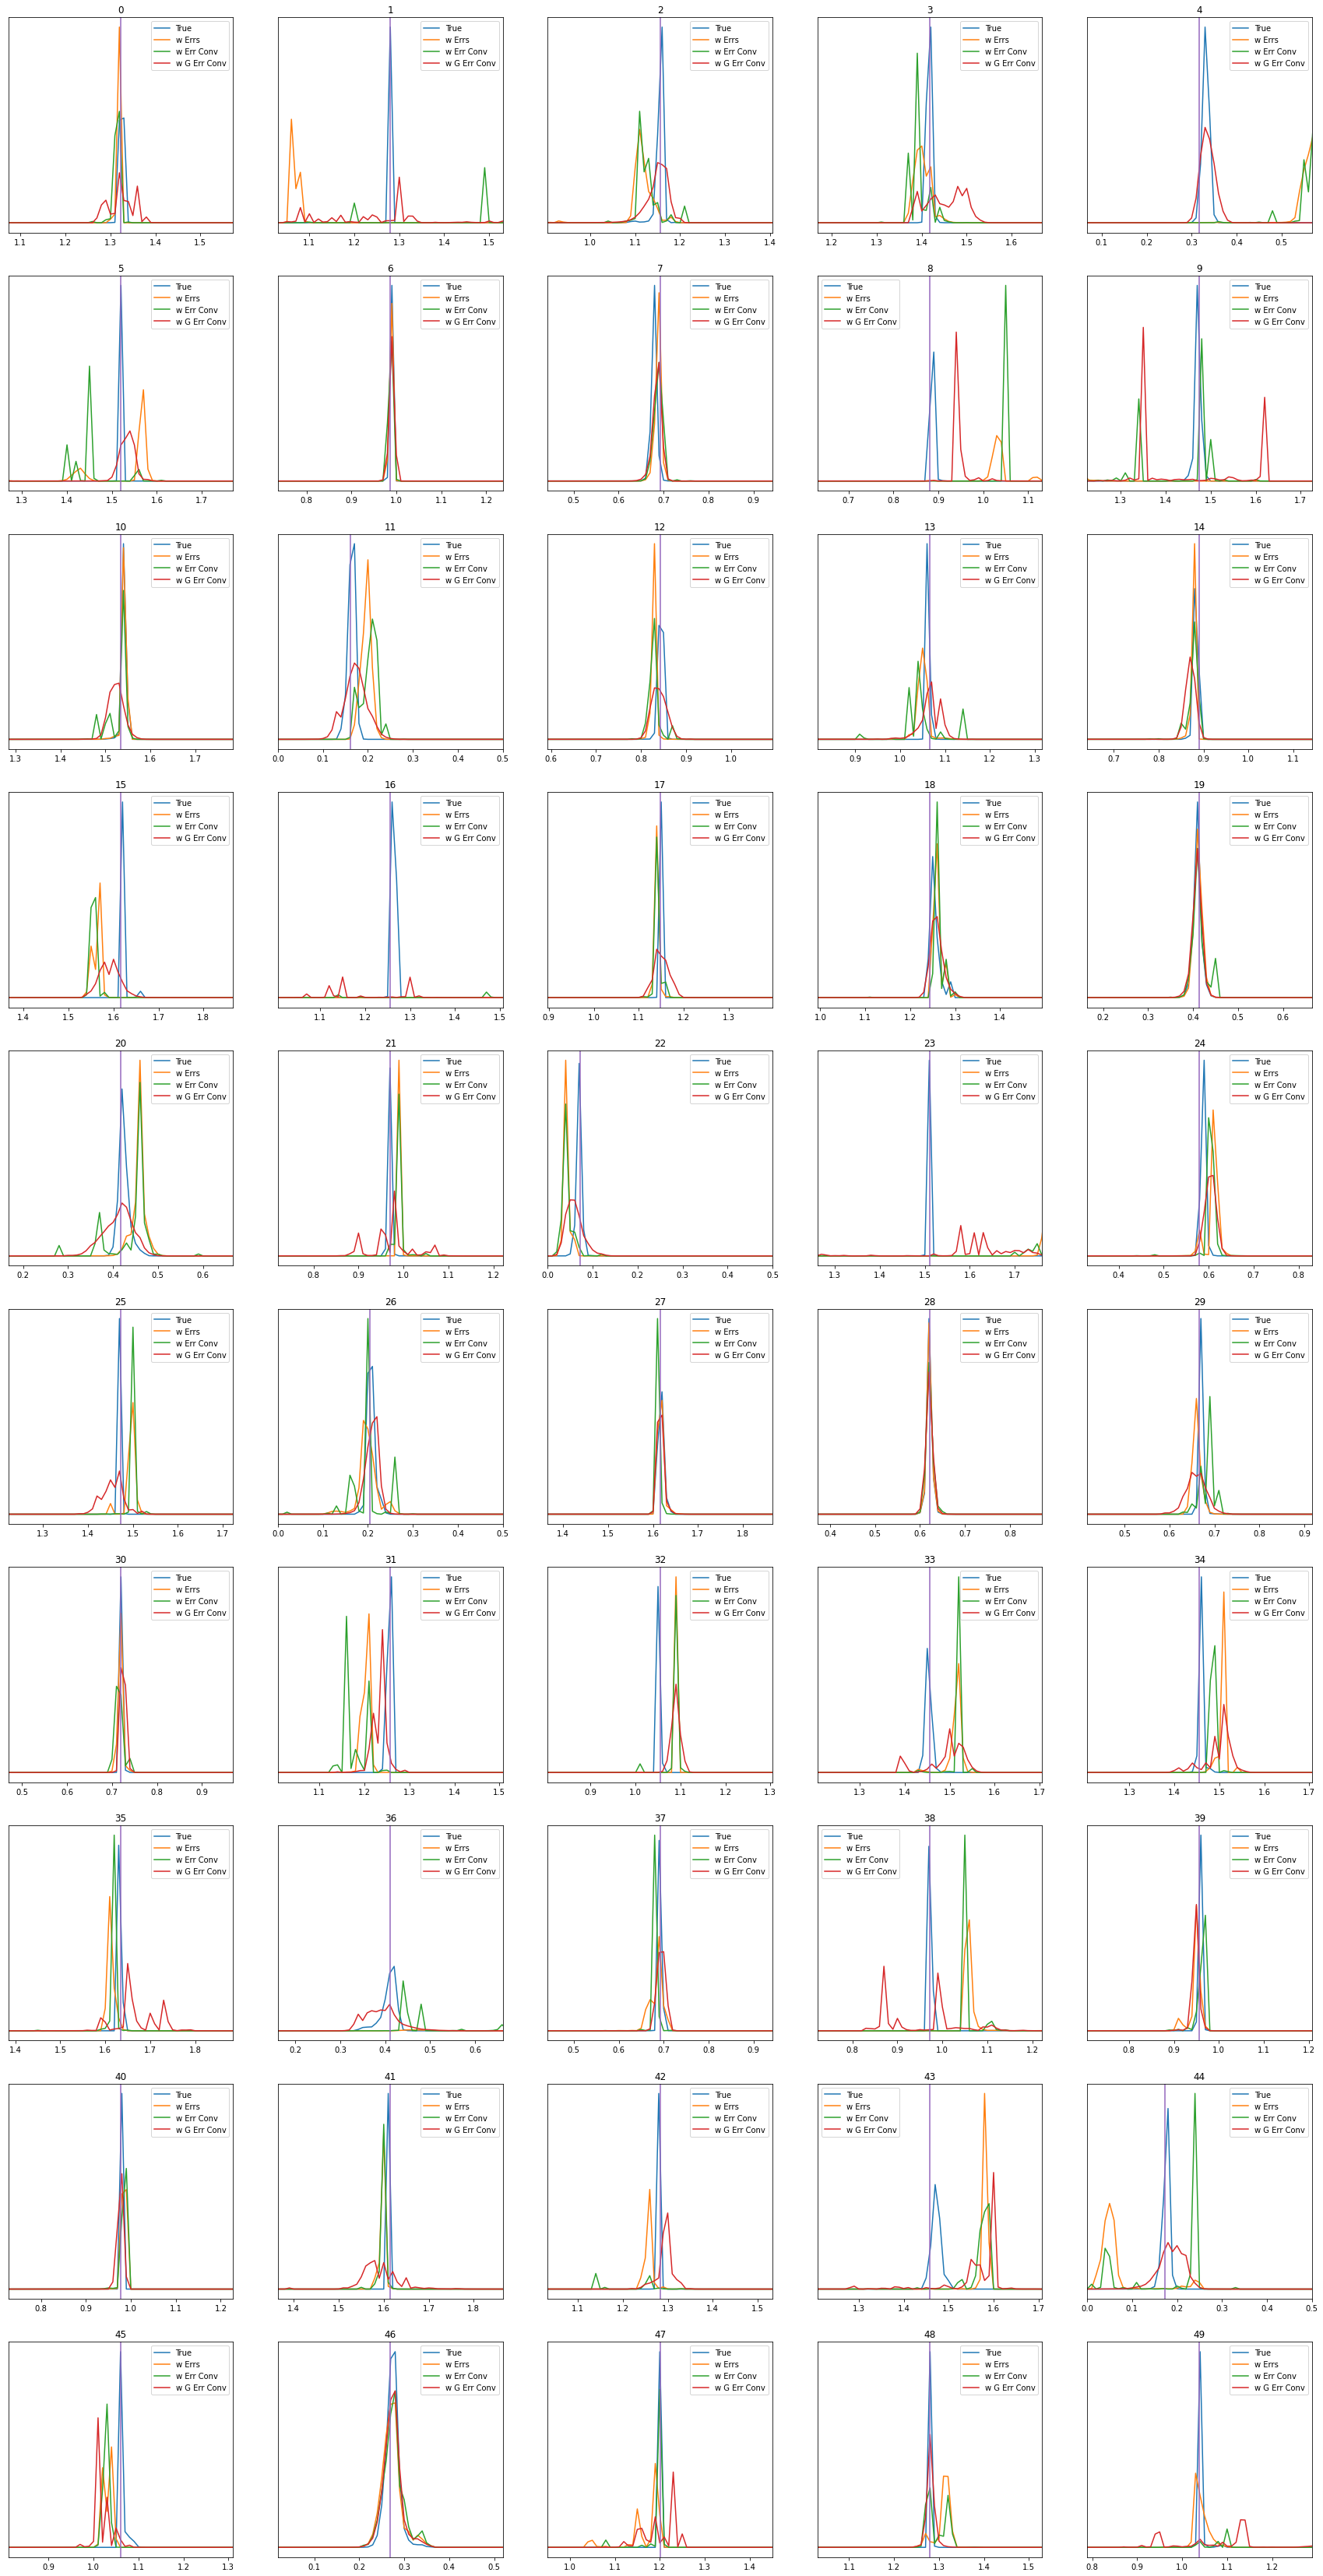

In [90]:
fig, axes = plt.subplots(N//5, 5, figsize=(20*3/2, 4*N//5*3/2))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(grid, pdfs0[i], label="True")
    ax.plot(grid, pdfs1[i], label="w Errs")
    ax.plot(grid, pdfs2[i], label="w Err Conv")
    ax.plot(grid, pdfs3_[i], label="w G Err Conv")
    ax.legend()
    
    ztrue = s["redshift"].values[i]
    ax.axvline(ztrue, c="C4")
    
    zmin = max(0, ztrue - 0.25)
    ax.set(xlim=(zmin, zmin + 0.5), yticks=[], title=i)
    
plt.show()

I will plot the progression of the marginalization for #2 above

In [109]:
Gsamples = []
np.random.seed(0)
J = 100000
gal = s.iloc[2]
for i in range(J):
    Gsamples.append( list(gal[:1]) + list(np.random.normal(gal[1:7], gal[7:])) )
Gsamples = pd.DataFrame(Gsamples, columns=samples.columns)

In [111]:
pdfs4 = flow.posterior(Gsamples, column="redshift", grid=grid, convolve_err=False, normalize=False)

In [117]:
def expval(N):
    pdf = pdfs4[:N].sum(axis=0)
    pdf /= pdf.sum() * (grid[1] - grid[0])
    return pdf

[(0.905532717704773, 1.405532717704773), []]

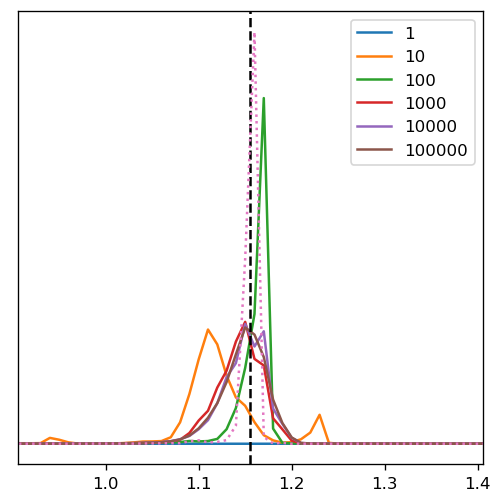

In [143]:
fig, ax = plt.subplots(figsize=(5,5), dpi=120)
for N in [1, 10, 100, 1000, 10000, 100000]:
    ax.plot(grid, expval(N), label=N)
    
ztrue = gal["redshift"]
ax.axvline(ztrue, c="k", ls="--")

ax.plot(grid, pdfs0[2], ls=":")

ax.legend()
    
zmin = max(0, ztrue - 0.25)
ax.set(xlim=(zmin, zmin + 0.5), yticks=[])

Note that the blue curve above looks flat because it's peak is actually outside the plot to the left (around 0.7ish)